# Generate word key

In [ ]:
import pandas as pd
import uuid
import os
import glob

# define relative path
path = '../res'
# Find all CSV files in the directory
csv_pattern = os.path.join(path, '*.csv')
csv_files = glob.glob(csv_pattern)

for csv_file in csv_files:
    
    print(f"\nProcessing: {os.path.basename(csv_file)}")
    
    # Load the CSV file
    df = pd.read_csv(csv_file)
    print(f"  Loaded {len(df)} rows")
    
    # Check if word_key column exists
    if 'word_key' in df.columns:
        print(f"  ✓ word_key column already exists - skipping")
        continue
    
    # Add UUID keys
    print(f"  Adding word_key column with UUID keys...")
    df['word_key'] = [str(uuid.uuid4()) for _ in range(len(df))]
    
    # Save back to the same file
    df.to_csv(csv_file, index=False)
    print(f"  ✓ Saved {len(df)} rows with UUID keys")



# Parse reading story

In [ ]:
import os
import re
import glob
import pandas as pd

path = r"~/Data/s10014/eye"

# load run dataset
folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
r_folders = [f for f in folders if re.search(r'_r[1-5]_', f)]
r_folders_sorted = sorted(r_folders, key=lambda x: int(re.search(r'_r(\d+)_', x).group(1)))

for folder in r_folders_sorted:
    folder_path = os.path.join(path, folder)
   
    # Look for _Message.csv file
    message_files = [f for f in os.listdir(folder_path) if f.endswith('_Message.csv')]

    if len(message_files) != 1:
        raise ValueError('Expected exactly 1 message file')
    
    df_msg = pd.read_csv(os.path.join(folder_path, message_files[0]))
    break

msg = 'TRIALID 1'
matching_indices = df_msg[df_msg['text'] == msg].index

if len(matching_indices) == 1:
   target_row = matching_indices[0] + 1  # Row 1 after the matching row
   
   if target_row < len(df_msg):
       text_value = df_msg.loc[target_row, 'text']
       reading_name = text_value.split('/')[1]
   else:
       raise ValueError('Cannot extract reading name')
else:
   raise ValueError('No reading data file found matching pattern')

res_path = '../res'
csv_pattern = os.path.join(res_path, f'{reading_name}*.csv')
matching_files = glob.glob(csv_pattern)

if matching_files:
   csv_file = matching_files[0]
   df_reading = pd.read_csv(csv_file)




# Generate page metadata

In [ ]:
import os
import glob
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def extract_cq_info(data_file):
    '''
    This function reads in psychopy csv file and extracts answers and subject
    responses to the comprehension questions

    Parameters
    ----------
    data_file : string
        DESCRIPTION. The path to PsychoPy csv file.

    Returns
    -------
    answer df: dataframe
        DESCRIPTION. df contains answers and subject responses

    '''
    # read the csv file
    df = pd.read_csv(data_file)
    # locate to rows that store answers and responses
    mask = np.where(pd.isnull(df['key_resp_question.keys']) == False)[0]
    reading = df.loc[mask, 'reading']
    answers = df.loc[mask, 'Answer']
    responses = df.loc[mask, 'key_resp_question.keys']
    pages = np.arange(len(reading))
    # create the return dataframe with these two series
    frame = {'reading': reading, 'page': pages, 'answer': answers, 'response':responses}
    
    return pd.DataFrame(frame)


# root path
path = r"~/Data"

# grab every sub folders under the input path
sub_folders = [f.path for f in os.scandir(path) if f.is_dir()]
# define group dataframe
df = pd.DataFrame()

# loop through every folder
for folder_path in sub_folders:
    # extract subject id
    subject_id = re.findall(r's[0-9]+', folder_path)
    if subject_id:
        subject_id = subject_id[0]
    else:
        continue  # Skip this iteration or handle the error as needed

    # extract tracking and behavior features
    file_path = glob.glob(os.path.join(folder_path, '**/*R[0-9]_MindlessReading_*.csv'))
    
    # for each psychopy csv file
    for file in file_path: 
        # read in the subject csv
        df_ind = extract_cq_info(file)
        # parse run number
        run = re.search(r'R[0-9]', file, re.IGNORECASE)
        run = int(run[0][-1])

        # reading
        reading = df_ind['reading'].values[0]
        # understandability
        understand = df_ind['response'].values[10]
        # prior knowledge
        pk = df_ind['response'].values[11]

        # compute accuracy
        resp = np.array(df_ind['response'].values[:10], dtype=float)
        ans = np.array(df_ind['answer'].values[:10], dtype=float)
        accuracy = np.mean(resp == ans)

        # Exclude responses where the answer is 5
        valid_idx = resp != 5
        filtered_resp = resp[valid_idx]
        filtered_ans = ans[valid_idx]
        filtered_accuracy = np.mean(filtered_resp == filtered_ans)

        # append the subject information to the dataframe
        new_row = {
            'sub_id': subject_id,
            'run': run,
            'reading': reading,
            'response': resp,
            'answer': ans,
            'is_correct': (resp == ans).astype(int),
            'story_accuracy': accuracy,
            'story_filtered_accuracy': filtered_accuracy,
            'story_understand': understand,
            'story_prior_knowledge': pk
        }
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

df.to_csv(os.path.join(path, 'ROAMM', 'reading_metadata.csv'), index=False)

# Manage files for OSF

## Copy raw data

In [ ]:
import os
import re
import shutil
# Define the root directory containing subject folders
# root_dir = "~/Data"
root_dir = r"~/Data"

# Define the expected number of files in each folder
expected_files_count = 5

# Regular expression to match subject folder names (s followed by exactly 5 digits)
subject_pattern = re.compile(r"^s\d{5}$")

# Get the list of subject folders that match the pattern
subjects = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d)) and subject_pattern.match(d)]

# Define the destination directory for raw data
raw_data_dir = os.path.join(r"/Users/~/Desktop/raw_data")

print(f"Found {len(subjects)} subjects matching pattern")
print(f"Raw data will be saved to: {raw_data_dir}")
print("-" * 50)

# Create the main raw_data directory
os.makedirs(raw_data_dir, exist_ok=True)

success_count = 0
skipped_count = 0
total_copied_files = {"eye": 0, "log": 0, "eeg": 0}

for subject in sorted(subjects):
    print(f"Processing subject: {subject}")
    
    # Source paths
    source_subject_dir = os.path.join(root_dir, subject)
    source_eye_dir = os.path.join(source_subject_dir, "eye")
    source_log_dir = os.path.join(source_subject_dir, "log")
    source_eeg_dir = os.path.join(source_subject_dir, "eeg")
    
    # Destination paths
    dest_subject_dir = os.path.join(raw_data_dir, subject)
    dest_eye_dir = os.path.join(dest_subject_dir, "eye")
    dest_log_dir = os.path.join(dest_subject_dir, "log")
    dest_eeg_dir = os.path.join(dest_subject_dir, "eeg")
    
    # Create destination directories
    os.makedirs(dest_eye_dir, exist_ok=True)
    os.makedirs(dest_log_dir, exist_ok=True)
    os.makedirs(dest_eeg_dir, exist_ok=True)
    
    # Check if destination folders already have the complete set of files
    existing_asc_files = [f for f in os.listdir(dest_eye_dir) if f.endswith('.asc')] if os.path.exists(dest_eye_dir) else []
    existing_csv_files = [f for f in os.listdir(dest_log_dir) if f.endswith('.csv')] if os.path.exists(dest_log_dir) else []
    existing_bdf_files = [f for f in os.listdir(dest_eeg_dir) if f.endswith('.bdf')] if os.path.exists(dest_eeg_dir) else []
    
    if (len(existing_asc_files) == expected_files_count and 
        len(existing_csv_files) == expected_files_count and 
        len(existing_bdf_files) == expected_files_count):
        print(f"  ⏭️  Skipping {subject} - already has complete set:")
        print(f"    - {len(existing_asc_files)} .asc files in eye folder")
        print(f"    - {len(existing_csv_files)} .csv files in log folder")
        print(f"    - {len(existing_bdf_files)} .bdf files in eeg folder")
        skipped_count += 1
        print()
        continue
    
    copied_files = {"eye": [], "log": [], "eeg": []}
    errors = []
    
    try:
        # Copy .asc files from eye folder
        if os.path.exists(source_eye_dir):
            asc_files = [f for f in os.listdir(source_eye_dir) if f.endswith('.asc')]
            
            if len(asc_files) == expected_files_count:
                for asc_file in asc_files:
                    source_file = os.path.join(source_eye_dir, asc_file)
                    dest_file = os.path.join(dest_eye_dir, asc_file)
                    shutil.copyfile(source_file, dest_file)
                    copied_files["eye"].append(asc_file)
            else:
                errors.append(f"Expected {expected_files_count} .asc files, found {len(asc_files)}")
        else:
            errors.append("Eye folder does not exist")
        
        # Copy .csv files from log folder
        if os.path.exists(source_log_dir):
            csv_files = [f for f in os.listdir(source_log_dir) if f.endswith('.csv')]
            
            if len(csv_files) == expected_files_count:
                for csv_file in csv_files:
                    source_file = os.path.join(source_log_dir, csv_file)
                    dest_file = os.path.join(dest_log_dir, csv_file)
                    shutil.copyfile(source_file, dest_file)
                    copied_files["log"].append(csv_file)
            else:
                errors.append(f"Expected {expected_files_count} .csv files, found {len(csv_files)}")
        else:
            errors.append("Log folder does not exist")
        
        # Copy .bdf files from eeg folder
        if os.path.exists(source_eeg_dir):
            bdf_files = [f for f in os.listdir(source_eeg_dir) if f.endswith('.bdf')]
            
            if len(bdf_files) == expected_files_count:
                for bdf_file in bdf_files:
                    source_file = os.path.join(source_eeg_dir, bdf_file)
                    dest_file = os.path.join(dest_eeg_dir, bdf_file)
                    shutil.copyfile(source_file, dest_file)
                    copied_files["eeg"].append(bdf_file)
            else:
                errors.append(f"Expected {expected_files_count} .bdf files, found {len(bdf_files)}")
        else:
            errors.append("EEG folder does not exist")
            
    except Exception as e:
        errors.append(f"Error copying files: {str(e)}")
    
    # Report results for this subject
    if errors:
        print(f"  ❌ Errors for {subject}:")
        for error in errors:
            print(f"    - {error}")
    else:
        print(f"  ✅ Successfully copied:")
        print(f"    - {len(copied_files['eye'])} .asc files from eye folder")
        print(f"    - {len(copied_files['log'])} .csv files from log folder")
        print(f"    - {len(copied_files['eeg'])} .bdf files from eeg folder")
        success_count += 1
        total_copied_files["eye"] += len(copied_files["eye"])
        total_copied_files["log"] += len(copied_files["log"])
        total_copied_files["eeg"] += len(copied_files["eeg"])
    
    print()

# Summary
print("=" * 50)
print("SUMMARY:")
print(f"Successfully processed: {success_count}/{len(subjects)} subjects")
print(f"Skipped (already had files): {skipped_count}/{len(subjects)} subjects")
print(f"Total .asc files copied: {total_copied_files['eye']}")
print(f"Total .csv files copied: {total_copied_files['log']}")
print(f"Total .bdf files copied: {total_copied_files['eeg']}")
print(f"Raw data directory: {raw_data_dir}")

## Generate demographic information

In [ ]:
import pandas as pd
import os

# Load the Excel file
path = r"~/Data/Files"
file_name = "demo_info.xlsx"  # Update path if needed
df = pd.read_excel(os.path.join(path, file_name))

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Find all subject folders from raw_data folder
raw_data_dir = r"~"
subject_pattern = re.compile(r"^s\d{5}$")

# Get subject IDs from raw_data folder
subject_ids = [d for d in os.listdir(raw_data_dir) 
               if os.path.isdir(os.path.join(raw_data_dir, d)) and subject_pattern.match(d)]

print(f"Found {len(subject_ids)} subjects in raw_data folder")
subject_nums = [int(s[1:]) for s in subject_ids]

# Filter by participant ID
df_filtered = df[df['participant_id'].isin(subject_nums)].copy()

# Age: ensure numeric and compute stats
df_filtered['age'] = pd.to_numeric(df_filtered['age'], errors='coerce')
age_min = df_filtered['age'].min()
age_max = df_filtered['age'].max()
age_median = df_filtered['age'].median()
age_mean = df_filtered['age'].mean()

# Gender: clean and count
df_filtered['gender_clean'] = df_filtered['gender'].str.strip().str.lower()
df_filtered['gender_clean'] = df_filtered['gender_clean'].replace({
    'female': 'female',
    'male': 'male',
    'nonbinary': 'non-binary',
    'non-binary': 'non-binary',
    'gender-nonconforming': 'non-binary',
    'transgender male': 'non-binary'
})
gender_counts = df_filtered['gender_clean'].value_counts()

# Handedness: clean and count
df_filtered['handness_clean'] = df_filtered['handness'].str.strip().str.lower()
df_filtered['handness_clean'] = df_filtered['handness_clean'].replace({
    'right': 'right',
    'left': 'left',
    'left, but used right-handed setup': 'left',
    'left-handed setup': 'left',
    'left, but used right-handed setup for mouse and keyboard': 'left',
    'ambidextrous (left-hand dominant)': 'left'
})
handness_counts = df_filtered['handness_clean'].value_counts()

# Print results
print("=" * 50)
print("DEMOGRAPHIC ANALYSIS")
print("=" * 50)
print(f"Total subjects analyzed: {len(df_filtered)}")
print()
print(f"Age range: {age_min} - {age_max}")
print(f"Median age: {age_median}")
print(f"Mean age: {age_mean:.2f}")
print()
print("Gender distribution:")
for gender, count in gender_counts.items():
    percentage = (count / len(df_filtered)) * 100
    print(f"  {gender}: {count} ({percentage:.1f}%)")
print()
print("Handedness distribution:")
for hand, count in handness_counts.items():
    percentage = (count / len(df_filtered)) * 100
    print(f"  {hand}: {count} ({percentage:.1f}%)")

# Optional: Show subjects that are in raw_data but missing from demographics
missing_subjects = [s for s in subject_nums if s not in df['participant_id'].values]
if missing_subjects:
    print()
    print(f"Warning: {len(missing_subjects)} subjects in raw_data have no demographic data:")
    print(f"Missing: {sorted(missing_subjects)}")

# Save filtered demographics to CSV in raw_data folder
output_file = os.path.join(raw_data_dir, "subject_demographics_information.csv")
df_filtered.to_csv(output_file, index=False)
print()
print(f"✅ Saved filtered demographics to: {output_file}")
print(f"   Contains {len(df_filtered)} subjects with {len(df_filtered.columns)} columns")

## Copy processed data

In [ ]:
import os
import re
import shutil
import glob

# Define the root directory containing subject folders
root_dir = r"~"

# Define the expected number of files in each folder
expected_files_count = 5

# Regular expression to match subject folder names (s followed by exactly 5 digits)
subject_pattern = re.compile(r"^s\d{5}$")

# Get the list of subject folders that match the pattern
subjects = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d)) and subject_pattern.match(d)]

# Define the destination directory for processed data
processed_data_dir = os.path.join(r"/Users/~/Desktop/processed_data")

print(f"Found {len(subjects)} subjects matching pattern")
print(f"Processed data will be saved to: {processed_data_dir}")
print("-" * 50)

# Create the main processed_data directory
os.makedirs(processed_data_dir, exist_ok=True)

# Define CSV file patterns to copy
csv_patterns = [
    '*end2_sr*.csv',
    '*end2_tp*.csv', 
    '*end5_sr*.csv',
    '*end5_tp*.csv',
    '*mw_fixed_sr*.csv',
    '*mw_fixed_tp*.csv',
    '*page_fixed_sr*.csv',
    '*page_fixed_tp*.csv',
    '*default_sr*.csv',
    '*slide2.0*.csv'
]

for subject in sorted(subjects):
    print(f"Processing subject: {subject}")
    
    subject_path = os.path.join(root_dir, subject)
    subject_processed_dir = os.path.join(processed_data_dir, subject)
    
    # Create subject directory in processed_data
    os.makedirs(subject_processed_dir, exist_ok=True)
    
    # Copy 5 folders from eye subdirectory
    eye_dir = os.path.join(subject_path, "eye")
    if os.path.exists(eye_dir):
        eye_folders = [d for d in os.listdir(eye_dir) if os.path.isdir(os.path.join(eye_dir, d))]
        
        if len(eye_folders) >= 5:
            # Copy first 5 folders (or you can modify this logic to select specific folders)
            for i, folder in enumerate(sorted(eye_folders)[:5]):
                src_folder = os.path.join(eye_dir, folder)
                dst_folder = os.path.join(subject_processed_dir, 'eye', folder)
                
                try:
                    shutil.copytree(src_folder, dst_folder)
                    # print(f"  Copied eye folder: {folder}")
                except Exception as e:
                    print(f"  Error copying eye folder {folder}: {e}")
        else:
            print(f"  Warning: Only found {len(eye_folders)} folders in eye directory, expected 5")
    else:
        print(f"  Warning: Eye directory not found for subject {subject}")
    
    # Copy CSV files with specified patterns
    for pattern in csv_patterns:
        matching_files = glob.glob(os.path.join(subject_path, pattern))
        
        for file_path in matching_files:
            file_name = os.path.basename(file_path)
            dst_path = os.path.join(subject_processed_dir, file_name)
            
            try:
                shutil.copy2(file_path, dst_path)
                # print(f"  Copied CSV: {file_name}")
                csv_files_copied += 1
            except Exception as e:
                print(f"  Error copying CSV {file_name}: {e}")
    
    print("-" * 30)

print("Processing complete!")

# Generate ML ready dataset

## Functions

In [1]:
import mne
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

def process_eeg_data(file_path):
    """
    Process EEG data and extract page start times.
    
    Parameters:
    file_path (str): Path to the EEG .set file
    
    Returns:
    tuple: (eeg_data, df_data, page_start_times, sampling_freq)
    """
    # Load EEG file
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    ch_names = raw.info['ch_names']
    
    # Get the data as numpy array
    data, times = raw.get_data(return_times=True)
    
    # Convert to dataframes
    eeg_data = pd.DataFrame(data.T, columns=ch_names)
    df_data = pd.DataFrame({'time': times})
    
    # Get sampling frequency and events
    fs = raw.info['sfreq']
    df_data['sfreq'] = fs
    
    events, event_id = mne.events_from_annotations(raw)
    
    # Extract page start times (condition 10 events)
    page_start_times = []
    
    if 'condition 10' in event_id:
        condition10_code = event_id['condition 10']
        condition10_events = events[events[:, 2] == condition10_code]
        
        if len(condition10_events) != 10:
            raise ValueError(f'Expected 10 pages, found {len(condition10_events)}')
        
        # Convert sample indices to time
        for event in condition10_events:
            page_sample = event[0]
            page_start_times.append(page_sample / fs)
    else:
        raise ValueError('condition 10 not found in event_id')
    
    # Clean up large variables to free memory
    del raw, data, times, events
    
    return pd.concat([eeg_data, df_data], axis=1), page_start_times, fs


def interpolate_blink(dfSamples, dfBlink, dfSaccade):
    """
    Interpolate left and right pupil sizes over blink periods. Modifies the
    dataframe of samples in place to change pupil dilation values to interpolated
    values, effectively removing blink artifacts. Saves interpolated data as csv.
    
    Uses saccades as t1 and t4. Contains adjustments recommended through conversation
    with Dr. J. Performs the interpolation over the normalized pupil dilation values.
    
    Inputs:
        - dfSamples: A dataframe containing samples for all subjects and all runs
        - dfBlink: A dataframe containing information about the eye in which a 
            blink occured and the time that that blink occured
        - dfSaccades: A dataframe of saccade events
        
    Returns:
        Interpolated dfSamples
    """
    # extracted from reading_analysis.py (author: HS)
    # interpolate the pupil size during the blink duration
    # http://dx.doi.org/10.6084/m9.figshare.688002
    

    # get time array from dfSamples
    sample_time = dfSamples['tSample'].to_numpy()

    # interpolate data for LEFT and RIGHT eye separately
    for eye in ['L', 'R']:
        # extract blink and saccade information for one eye
        dfBlink_ = dfBlink[dfBlink['eye']==eye]
        dfSaccade_ = dfSaccade[dfSaccade['eye']==eye]

        # truncate blink dataframe using the saccade information
        t_start = dfSaccade_['tStart'].min()
        t_end = dfSaccade_['tEnd'].max()
        mask = (dfBlink_['tStart'] > t_start) & (dfBlink_['tEnd'] < t_end)
        dfBlink_ = dfBlink_[mask]

        # convert df columns to np.arrays for interpolation
        col_names = [f'{eye}X', f'{eye}Y', f'{eye}Pupil']
        data_to_interpolate = []
        for col_name in col_names:
            data_to_interpolate.append(np.array(dfSamples[col_name]))

        # iterate throu each row of blink dataframe
        for index in np.arange(len(dfBlink_)):
            row = dfBlink_.iloc[index]
            # get the start and end time
            b_start = row['tStart'] 
            b_end = row['tEnd']
            # skip blinks out of range of dfSamples
            if (b_start < sample_time[0]) and (b_end > sample_time[-1]):
                continue

            # set t1 to be the end time of the last saccade before the blink
            #get all saccades before this blink
            previous_sac = dfSaccade_[dfSaccade_["tEnd"] < b_start]
            # get last saccade before this blink
            t1 = previous_sac["tEnd"].max()
            # set t4 to be the start time of the first saccade after the blink
            # get all saccades after this blink
            after_sac = dfSaccade_[dfSaccade_["tStart"] > b_end]
            # get the first saccade after this blink
            t2 = after_sac["tStart"].min()

            # check for missing vals in t1 or t4 and use fallback if needed
            # if pd.isna(t1) or pd.isna(t2):
            #     raise ValueError("t1/t2 are Na")
            
            # check the timing of saccades are within the time array for samples
            if (t1 > sample_time[0]) and (t2 < sample_time[-1]):
                # choose data points for interpolation function
                x = [t1,t2]
                y_ind = []
                for t in x:
                    y_ind.append(np.where(sample_time==t)[0][0])

                # loop thru all columns
                for col_name, col_data in zip(col_names, data_to_interpolate):
                    # create the 1D function for interpolation
                    y = col_data[y_ind]
                    interp_f = interp1d(x, y)           
                    #spl = CubicSpline(x, y)
                    
                    # generate mask for blink duration
                    mask = (sample_time > t1) & (sample_time < t2)
                    time_to_interpolate = sample_time[mask]
                    # use spl model to interpolate data during blink duration
                    interp_data = interp_f(time_to_interpolate)
                    
                    # update the dfSamples in place
                    dfSamples.loc[mask, col_name] = interp_data

    return dfSamples


def convert_eyelink_to_image_pixel(x_eyelink, y_eyelink):
        '''
        Convert eyeylink coords to pixel for image (1900 x 1442 pixels) 
        displayed at pos (0, 0) w/ size (1.3, 0.99) in PsychoPy.

        Parameters
        ----------
        x_eyelink : float
            DESCRIPTION. eyelink coord unit
        y_eyelink : float
            DESCRIPTION. eyelink coord unit

        Returns
        -------
        x_pixel : float
            DESCRIPTION. Image pixel unit
        y_pixel : float 
            DESCRIPTION. Image pixel unit 

        '''
        x_pixel = (x_eyelink-258) * 1900 / (1080*1.3)
        y_pixel = (y_eyelink-5.4) * 1442 / (1080*0.99)
        return x_pixel, y_pixel


def find_match(dfWords, coord_info, dist_max=1000):
    '''
    Match the clicks to words. 

    Parameters
    ----------
    dfWords : DataFrame
        DESCRIPTION. The dataframe for a single page. It should at least contain
        columns 'center_x', 'center_y', 'width', and 'height', which are 
        coordinate information of words in pixel unit
    click_pos : Tuple
        DESCRIPTION. The coordinate info (x, y) for a click in pixel unit

    Returns
    -------
    matched_index: int
        DESCRIPTION. The index value of matched word for input dataframe. 

    '''
    # compute the start and end positions of words
    words_x_start = dfWords['center_x'] - dfWords['width']/2
    words_x_end = dfWords['center_x'] + dfWords['width']/2
    words_y_start = dfWords['center_y'] - dfWords['height']/2
    words_y_end = dfWords['center_y'] + dfWords['height']/2
    
    # get x and y for the click
    pos_x, pos_y = coord_info
    
    # compute the distance between click and word boundry box
    dist_x_left = (words_x_start - pos_x)
    dist_x_right = (pos_x - words_x_end)
    dist_y_top = (words_y_start - pos_y)
    dist_y_bottom = (pos_y - words_y_end)
    
    # find the maximum distance from click to the word for x and y
    max_x = np.max(np.vstack((dist_x_left, dist_x_right, np.zeros(len(dist_x_left)))), axis=0)
    max_y = np.max(np.vstack((dist_y_top, dist_y_bottom, np.zeros(len(dist_y_top)))), axis=0)
    
    # calculate the distance using x and y
    dist = np.sqrt(np.square(max_x) + np.square(max_y))
    
    # check if the minimum dist exceeds threshold values
    if np.min(dist) < dist_max:
        matched_index = np.argmin(dist)
    else:
        matched_index = -1
    
    # return the index that has the shortest distance
    return matched_index

## Pipeline

In [ ]:
# Define the root directory containing subject folders
root_dir = r"~"

# Regular expression to match subject folder names (s followed by exactly 5 digits)
subject_pattern = re.compile(r"^s\d{5}$")

# Get the list of subject folders that match the pattern
subjects = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d)) and subject_pattern.match(d)]

for subject_path in subjects:
    sub_id = re.search(r'^s\d{5}$', subject_path).group(0)
    

    

s10110


In [ ]:
import os
import re
import glob
import pandas as pd
# Define the root directory containing subject folders
# root_dir = "~/Data"
root_dir = r"~/Data"
# Regular expression to match subject folder names (s followed by exactly 5 digits)
subject_pattern = re.compile(r"^s\d{5}$")

# Get the list of subject folders that match the pattern
subjects = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d)) and subject_pattern.match(d)]

# define res path (relative)
res_path = '../res'

for sub_id in subjects:
    print('Start processing subject: ', sub_id)
    subject_path = os.path.join(root_dir, sub_id)
    # define path to save
    path_to_save = os.path.join(subject_path, 'ml_data')
    os.makedirs(path_to_save, exist_ok=True)

    # load subject page info dataframe
    file_path = os.path.join(subject_path, f'{sub_id}_R_features_default_sr.csv')
    df_page_info = pd.read_csv(file_path)

    # load raw eye datasets for each run
    eye_folder = os.path.join(subject_path, 'eye')
    folders = [f for f in os.listdir(eye_folder) if os.path.isdir(os.path.join(eye_folder, f))]
    r_folders = [f for f in folders if re.search(r'_r[1-5]_', f)]
    r_folders_sorted = sorted(r_folders, key=lambda x: int(re.search(r'_r(\d+)_', x).group(1)))

    for folder in r_folders_sorted:
        folder_path = os.path.join(eye_folder, folder)
        # get run number
        run_num = int(re.search(r'_r(\d+)_', folder).group(1))
        print('Run number: ', run_num)

        # load EEG file for the current run
        file_path = os.path.join(subject_path, 'eeg', 'ICAPruned', f'MR_{sub_id}_r{run_num}_ICAPruned.set')
        df_data, page_start_eeg, fs = process_eeg_data(file_path)

        # get the current run info
        df_page_run = df_page_info[df_page_info['run']==run_num].copy()
        eyelink_start_time = df_page_run['task_start'].iloc[0]
        # page start time in eyelink
        page_start_eye = df_page_run['page_start'] - eyelink_start_time

        # make sure time offsets between eeg and eyelink are consistent
        time_offsets = np.array(page_start_eeg) - np.array(page_start_eye)
        max_offset_allowed = 0.01
        if np.max(time_offsets) - np.min(time_offsets) > max_offset_allowed:
            raise ValueError('Time offsets between EEG and eyelink not consistent.')
        # use the mean to be the time offset (in seconds) for the current run
        time_offset = np.mean(time_offsets)

        # update eyelink time to match df_data array
        df_page_run['page_start_eeg'] = df_page_run['page_start'] - eyelink_start_time + time_offset
        df_page_run['page_end_eeg'] = df_page_run['page_end'] - eyelink_start_time + time_offset
        df_page_run['mw_onset'] = df_page_run['mw_onset'] - eyelink_start_time + time_offset
        df_page_run['mw_offset'] = df_page_run['mw_offset'] - eyelink_start_time + time_offset

        # get story name
        story_name = df_page_run['reading'].iloc[0]
        story_name = story_name.lower().replace(' ', '_')

        # load word coordinate file
        csv_pattern = os.path.join(res_path, f'{story_name}*.csv')
        matching_files = glob.glob(csv_pattern)
        df_word = pd.read_csv(matching_files[0])

        # load fixation file
        csv_pattern = os.path.join(folder_path, f'*Fixation.csv')
        matching_files = glob.glob(csv_pattern)
        df_fix = pd.read_csv(matching_files[0])

        # load blink file
        csv_pattern = os.path.join(folder_path, f'*Blink.csv')
        matching_files = glob.glob(csv_pattern)
        df_blink = pd.read_csv(matching_files[0])

        # load saccade file
        csv_pattern = os.path.join(folder_path, f'*Saccade.csv')
        matching_files = glob.glob(csv_pattern)
        df_sacc = pd.read_csv(matching_files[0])

        # load raw eye sample file (gaze position and pupil size)
        csv_pattern = os.path.join(folder_path, f'*Sample.csv')
        matching_files = glob.glob(csv_pattern)
        df_sample = pd.read_csv(matching_files[0])

        # interpolate eye samples during blinnk
        df_interp_sample = df_sample.copy()
        interpolate_blink(df_interp_sample, df_blink, df_sacc)
        # copy interpolated data into the samples dataframe
        for col in ['LX', 'LY', 'LPupil', 'RX', 'RY', 'RPupil']:
            df_sample[f'blink_interp_{col}'] = df_interp_sample[col]
        
        # loop through each page for matching fixation and word and inserting page-level information
        for _, row in df_page_run.iterrows():
            # get the current page number
            page_num = row['page']
            # get the page number start and end time
            page_start = row['page_start'] * 1000
            page_end = row['page_end'] * 1000

            # match fixation to the reading word
            # find the fixation and words for the current page
            df_word_page = df_word[df_word['page']==page_num]
            mask = (df_fix['tStart'] >= page_start) & (df_fix['tEnd'] <= page_end)
            df_fix_page = df_fix[mask]
            # loop through each fixation and match it to the closed word 
            for row_index, fix in df_fix_page.iterrows():
                # get the fixtaion position x and y
                x_eyelink = fix['xAvg']
                y_eyelink = fix['yAvg']
                # convert position x and y into image pixel unit
                fix_x, fix_y = convert_eyelink_to_image_pixel(x_eyelink, y_eyelink)
                
                # call function find the matched index
                matched_index = find_match(df_word_page, (fix_x, fix_y))
                
                if matched_index >= 0:
                    # store matched word info into fixations 
                    df_fix.at[row_index, 'fixed_word'] = df_word_page['words'].iloc[matched_index]
                    df_fix.at[row_index, 'fixed_word_key'] = df_word_page['word_key'].iloc[matched_index]
        

            # insert page start and end time to df_data
            page_mask = (df_data['time'] >= row['page_start_eeg']) & (df_data['time'] <= row['page_end_eeg'])
            df_data.loc[page_mask, 'first_pass_reading'] = True
            df_data.loc[page_mask, 'page_num'] = page_num
            df_data.loc[page_mask, 'page_start'] = row['page_start_eeg']
            df_data.loc[page_mask, 'page_end'] = row['page_end_eeg']
            df_data.loc[page_mask, 'page_dur'] = row['page_end_eeg'] - row['page_start_eeg']
            # insert mw start and end time to df_data
            mw_mask = (df_data['time'] >= row['mw_onset']) & (df_data['time'] <= row['mw_offset'])
            df_data.loc[mw_mask, 'is_mw'] = True
            df_data.loc[mw_mask, 'mw_onset'] = row['mw_onset']
            df_data.loc[mw_mask, 'mw_offset'] = row['mw_offset']
            df_data.loc[mw_mask, 'mw_dur'] = row['mw_offset'] - row['mw_onset']

        print('Aligning eye-tracking data into EEG time...')
        # insert current run information
        df_data['run_num'] = run_num
        df_data['story_name'] = story_name

        # insert fixations to df_data
        # align fixation time to eeg
        # 1. /1000: ms -> s
        # 2. - eyelink_start_time: take off the run start time
        # 3. + time_offset: add on the time offset between eeg and eye
        for col in ['tStart', 'tEnd']:
            df_fix[col] = df_fix[col]/1000 - eyelink_start_time + time_offset
        for _, row in df_fix.iterrows():
            mask = (df_data['time'] >= row['tStart']) & (df_data['time'] <= row['tEnd'])
            if mask.sum() > 0:
                df_data.loc[mask, 'is_fixation'] = True
                for col in df_fix.columns:
                    df_data.loc[mask, f'fix_{col}'] = row[col]
        
        # insert blinks to df_data
        for col in ['tStart', 'tEnd']:
            df_blink[col] = df_blink[col]/1000 - eyelink_start_time + time_offset
        for _, row in df_blink.iterrows():
            mask = (df_data['time'] >= row['tStart']) & (df_data['time'] <= row['tEnd'])
            if mask.sum() > 0:
                df_data.loc[mask, 'is_blink'] = True
                for col in df_blink.columns:
                    df_data.loc[mask, f'blink_{col}'] = row[col]

        # insert saccades to df_data
        for col in ['tStart', 'tEnd']:
            df_sacc[col] = df_sacc[col]/1000 - eyelink_start_time + time_offset
        for _, row in df_sacc.iterrows():
            mask = (df_data['time'] >= row['tStart']) & (df_data['time'] <= row['tEnd'])
            if mask.sum() > 0:
                df_data.loc[mask, 'is_saccade'] = True
                for col in df_sacc.columns:
                    df_data.loc[mask, f'sacc_{col}'] = row[col]

        # insert gaze position and pupil size to df_data
        df_sample['tSample'] = df_sample['tSample']/1000 - eyelink_start_time + time_offset
        # instead of interpolating, find the closest eye sample point time for each eeg data point
        eeg_times = df_data['time'].values
        sample_times = df_sample['tSample'].values
        for i, eeg_time in enumerate(eeg_times):
            # Find index of closest sample time
            closest_idx = np.argmin(np.abs(sample_times - eeg_time))
            
            # Check if it's within reasonable range (optional)
            time_diff = abs(sample_times[closest_idx] - eeg_time)
            if time_diff < 0.01:
                for col in df_sample.columns:
                    df_data.loc[i, col] = df_sample.iloc[closest_idx][col]
        
        dataset_name = f'{sub_id}_run{run_num}_ml_data.csv'
        df_data.to_csv(os.path.join(path_to_save, dataset_name), index=False)
        print(f'Subject {sub_id} run {run_num} has done! Data saved to {os.path.join(path_to_save, dataset_name)}\n')
    
    break
    


# Dataset validation

## Dataset header

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import seaborn as sns

def load_ml_data(subject_id, run_number, data_root=r"/Users/~/"):
    """
    Load ML-ready dataset with synchronized EEG and eye-tracking data
    
    Parameters:
    subject_id (str): Subject ID (e.g., 's10014')
    run_number (int): Run number (1-5)
    data_root (str): Root directory containing subject data
    
    Returns:
    pandas.DataFrame: Combined EEG and eye-tracking data
    """
    file_path = os.path.join(data_root, subject_id, f'{subject_id}_run{run_number}_ml_data.pkl')
    
    print(f"Loading data from: {file_path}")
    df = pd.read_pickle(file_path)
    print(f"Loaded {len(df)} samples with {len(df.columns)} columns")
    print(f"Time range: {df['time'].min():.2f} - {df['time'].max():.2f} seconds")
    
    return df


def visualize_df_header_grouped(df):
    """
    Generate a markdown table showing DataFrame columns grouped by category
    """
    # Define column categories
    # EEG: First 64 columns
    eeg_cols = df.columns[:64].tolist()
    
    eye_cols = [col for col in df.columns if any(eye_term in col.lower() for eye_term in 
                ['gaze', 'pupil', 'blink', 'saccade', 'fixation', 'eye', 'sacc', 'fix']) or 
                col in ['LX', 'LY', 'RX', 'RY']]
    
    time_cols = [col for col in df.columns if col in ['time', 'page_start', 'page_end', 'mw_onset', 'mw_offset', 'mw_dur', 'tSample', 'page_dur']]
    
    label_cols = [col for col in df.columns if col in ['is_mw', 'fix_fixed_word', 'first_pass_reading'] or col.endswith('_key')]
    
    # Merge misc and other columns into "Others"
    categorized = set(eeg_cols + eye_cols + time_cols + label_cols)
    others_cols = [col for col in df.columns if col not in categorized]
    
    # Create category information
    categories = [
        {
            'group': 'EEG',
            'count': len(eeg_cols),
            'description': '64 electrode EEG signals',
            'examples': ', '.join(eeg_cols[:5]) + ('...' if len(eeg_cols) > 5 else '')
        },
        {
            'group': 'Eye-Tracking',
            'count': len(eye_cols),
            'description': 'Gaze position, pupil size, fixations, saccades, and blink',
            'examples': ', '.join(eye_cols[:5]) + ('...' if len(eye_cols) > 5 else '')
        },
        {
            'group': 'Time',
            'count': len(time_cols),
            'description': 'Time-related variables including timestamps, page boundaries, and mind-wandering episodes',
            'examples': ', '.join(time_cols[:5]) + ('...' if len(time_cols) > 5 else '')
        },
        {
            'group': 'Others',
            'count': len(others_cols),
            'description': 'Sampling frequency, run and page numbers, story name',
            'examples': ', '.join(others_cols[:5]) + ('...' if len(others_cols) > 5 else '')
        },
        {
            'group': 'Labels',
            'count': len(label_cols),
            'description': 'First-pass reading, mind-wandering and fixated word annotations',
            'examples': ', '.join(label_cols[:5]) + ('...' if len(label_cols) > 5 else '')
        }
    ]
    
    # Filter out empty categories
    categories = [cat for cat in categories if cat['count'] > 0]
    
    # Generate markdown table
    print("## Dataset Structure Overview\n")
    print("| Data Category | Column Count | Description | Example Columns |")
    print("|---------------|--------------|-------------|-----------------|")
    
    total_cols = 0
    for cat in categories:
        total_cols += cat['count']
        print(f"| **{cat['group']}** | {cat['count']} | {cat['description']} | `{cat['examples']}` |")
    
    print(f"\n**Total Columns:** {total_cols}")
    print(f"**Dataset Shape:** {df.shape[0]:,} samples × {df.shape[1]} features")
    
    # Print detailed column lists for reference
    print("\n---\n")
    print("### Detailed Column Breakdown\n")
    
    if eeg_cols:
        print(f"**EEG Channels ({len(eeg_cols)}):**")
        print(f"`{', '.join(eeg_cols)}`\n")
    
    if eye_cols:
        print(f"**Eye-Tracking Features ({len(eye_cols)}):**")
        print(f"`{', '.join(eye_cols)}`\n")
    
    if time_cols:
        print(f"**Temporal Features ({len(time_cols)}):**")
        print(f"`{', '.join(time_cols)}`\n")
    
    if others_cols:
        print(f"**Experimental Variables ({len(others_cols)}):**")
        print(f"`{', '.join(others_cols)}`\n")
    
    if label_cols:
        print(f"**Target Labels ({len(label_cols)}):**")
        print(f"`{', '.join(label_cols)}`\n")


df = load_ml_data('s10014', 1)
visualize_df_header_grouped(df)



## Plot sync EEG and eye

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

def load_ml_data(subject_id, run_number, data_root=r"~/Data"):
    """
    Load ML-ready dataset with synchronized EEG and eye-tracking data
    
    Parameters:
    subject_id (str): Subject ID (e.g., 's10014')
    run_number (int): Run number (1-5)
    data_root (str): Root directory containing subject data
    
    Returns:
    pandas.DataFrame: Combined EEG and eye-tracking data
    """
    file_path = os.path.join(data_root, subject_id, 'ml_data', f'{subject_id}_run{run_number}_ml_data.pkl')
    
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        print("Available files:")
        ml_dir = os.path.join(data_root, subject_id, 'ml_data')
        if os.path.exists(ml_dir):
            files = os.listdir(ml_dir)
            for f in files:
                print(f"  {f}")
        return None
    
    print(f"Loading data from: {file_path}")
    df = pd.read_pickle(file_path)
    print(f"Loaded {len(df)} samples with {len(df.columns)} columns")
    print(f"Time range: {df['time'].min():.2f} - {df['time'].max():.2f} seconds")
    
    return df

def get_representative_channels(all_channels, mode='comprehensive'):
    """
    Select representative EEG channels from different brain regions
    
    Parameters:
    all_channels (list): List of all available EEG channel names
    mode (str): Selection mode - 'comprehensive', 'reading', 'attention', or 'minimal'
    
    Returns:
    list: Selected representative channels with region labels
    """
    
    # Define representative channels by brain region (standard 10-20 system)
    channel_regions = {
        # Frontal regions (executive control, attention)
        'Frontal': ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz', 'FC1', 'FC2'],
        
        # Central regions (sensorimotor)
        'Central': ['C3', 'C4', 'Cz', 'CP1', 'CP2'],
        
        # Parietal regions (attention, spatial processing)
        'Parietal': ['P3', 'P4', 'Pz', 'P7', 'P8'],
        
        # Temporal regions (language, memory)
        'Temporal': ['T7', 'T8', 'TP9', 'TP10'],
        
        # Occipital regions (visual processing)
        'Occipital': ['O1', 'O2', 'Oz'],
        
        # Additional channels for comprehensive coverage
        'Additional': ['AF3', 'AF4', 'FC5', 'FC6', 'CP5', 'CP6', 'PO3', 'PO4']
    }
    
    # Different selection modes
    if mode == 'minimal':
        priority_channels = ['Fz', 'Cz', 'Pz', 'Oz', 'F3', 'F4', 'P3', 'P4']
    elif mode == 'reading':
        # Focus on language and reading-related areas
        priority_channels = ['F3', 'F4', 'T7', 'T8', 'P3', 'P4', 'O1', 'O2', 
                           'Fz', 'Pz', 'C3', 'C4', 'TP9', 'TP10']
    elif mode == 'attention':
        # Focus on attention and executive control
        priority_channels = ['F3', 'F4', 'Fz', 'P3', 'P4', 'Pz', 'C3', 'C4', 
                           'FC1', 'FC2', 'CP1', 'CP2']
    else:  # comprehensive
        priority_channels = ['Fz', 'Cz', 'Pz', 'Oz',  # Midline
                           'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',  # Bilateral
                           'T7', 'T8', 'F7', 'F8',  # Temporal/lateral
                           'FC1', 'FC2', 'CP1', 'CP2']  # Additional coverage
    
    # Find available channels from priority list
    selected_channels = []
    channel_labels = []
    
    for channel in priority_channels:
        if channel in all_channels:
            selected_channels.append(channel)
            # Add region label
            region = 'Unknown'
            for reg_name, reg_channels in channel_regions.items():
                if channel in reg_channels:
                    region = reg_name
                    break
            channel_labels.append(f"{channel} ({region})")
    
    # If we don't have enough representative channels, fill with available ones
    if len(selected_channels) < 8:
        remaining_channels = [ch for ch in all_channels if ch not in selected_channels]
        needed = min(16 - len(selected_channels), len(remaining_channels))
        for i in range(needed):
            selected_channels.append(remaining_channels[i])
            channel_labels.append(f"{remaining_channels[i]} (Other)")
    
    return selected_channels, channel_labels

def plot_eeg_eyetracking_sync(df_data, time_start=100, time_end=110, 
                              eeg_channels=None, channel_mode='comprehensive'):
    """
    Create synchronized plots of EEG and eye-tracking data with representative channels
    
    Parameters:
    df_data (DataFrame): Combined EEG and eye-tracking data
    time_start (float): Start time in seconds
    time_end (float): End time in seconds
    eeg_channels (list): List of EEG channel names (if None, selects representative channels)
    channel_mode (str): Channel selection mode - 'comprehensive', 'reading', 'attention', or 'minimal'
    """
    
    # Filter data for time window
    mask = (df_data['time'] >= time_start) & (df_data['time'] <= time_end)
    df_plot = df_data[mask].copy()
    
    if len(df_plot) == 0:
        print(f"No data found in time range {time_start}-{time_end}")
        return
    
    time = np.array(df_plot['time'])
    
    # Get all available EEG channel names
    non_eeg_cols = ['time', 'sfreq', 'run_num', 'story_name', 'first_pass_reading', 
                   'page_num', 'page_start', 'page_end', 'page_dur', 'is_mw', 
                   'mw_onset', 'mw_offset', 'mw_dur']
    all_eeg_channels = [col for col in df_plot.columns if col not in non_eeg_cols 
                       and not col.startswith(('is_', 'fix_', 'blink_', 'sacc_', 'tSample', 'LX', 'LY', 'RX', 'RY'))]
    
    # Select representative channels
    if eeg_channels is None:
        eeg_channels, channel_labels = get_representative_channels(all_eeg_channels, mode=channel_mode)
    else:
        channel_labels = [f"{ch} (Custom)" for ch in eeg_channels]
    
    print(f"Plotting {len(eeg_channels)} representative EEG channels from {time_start} to {time_end} seconds")
    print(f"Channel selection mode: {channel_mode}")
    print(f"Selected channels: {', '.join(eeg_channels)}")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))
    
    # EEG plot (top subplot)
    ax1 = plt.subplot(3, 1, 1)
    
    # Get EEG data
    eeg_data = np.array(df_plot[eeg_channels])
    
    # Vertical spacing between channels
    channel_spacing = np.std(eeg_data) * 3
    
    # Group channels by brain region in reverse anatomical order (occipital to frontal)
    region_order = ['Occipital', 'Temporal', 'Parietal', 'Central', 'Frontal', 'Additional', 'Other', 'Custom']
    region_colors = {
        'Frontal': 'blue',
        'Central': 'green', 
        'Parietal': 'orange',
        'Temporal': 'red',
        'Occipital': 'purple',
        'Additional': 'brown',
        'Other': 'gray',
        'Custom': 'black'
    }
    
    # Group channels by region
    channels_by_region = {}
    for i, label in enumerate(channel_labels):
        region = label.split('(')[1].split(')')[0] if '(' in label else 'Other'
        if region not in channels_by_region:
            channels_by_region[region] = []
        channels_by_region[region].append((eeg_channels[i], label, i))
    
    # Plot channels grouped by region in anatomical order
    current_y_offset = 0
    region_boundaries = []
    
    for region in region_order:
        if region in channels_by_region:
            color = region_colors[region]
            region_start = current_y_offset
            
            # Plot all channels in this region
            for channel_name, label, orig_idx in channels_by_region[region]:
                ax1.plot(time, eeg_data[:, orig_idx] + current_y_offset, 
                        color=color, linewidth=0.8, alpha=0.8)
                
                # Add original channel names on the left inside
                ax1.text(time_start - (time_end - time_start) * 0.01, current_y_offset, channel_name, 
                        verticalalignment='center', horizontalalignment='left',
                        fontsize=8, color=color)
                current_y_offset += channel_spacing
            
            # Add region separator and label
            region_end = current_y_offset - channel_spacing/2
            region_boundaries.append((region, region_start, region_end, color))
            
            # Add some extra space between regions
            current_y_offset += channel_spacing * 0.3
    
    # Add region labels on the right/outside
    for region, start_y, end_y, color in region_boundaries:
        region_center = (start_y + end_y) / 2
        ax1.text(time_end + (time_end - time_start) * 0.01, region_center, region, 
                verticalalignment='center', horizontalalignment='left',
                fontsize=10, fontweight='bold', color=color,
                bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.2))
    
    # Set ylabel with consistent positioning from left edge
    ax1.text(-0.05, 0.5, 'EEG Channels', 
             transform=ax1.transAxes, fontsize=12, fontweight='bold',
             verticalalignment='center', horizontalalignment='center',
             rotation=90)
    ax1.set_title(f'Synchronized EEG and Eye-Tracking Data ({time_end-time_start}s)', 
                 fontsize=14, fontweight='bold')
    ax1.set_ylim(-channel_spacing, current_y_offset)
    ax1.set_yticks([])
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(time_start, time_end)
    
    # Eye movement events (middle subplot)
    ax2 = plt.subplot(3, 1, 2)
    
    # Plot fixations, saccades, and blinks
    y_pos = 0
    colors = ['green', 'orange', 'red']
    labels = ['Fixation', 'Saccade', 'Blink']
    
    for event_type, color, label in zip(['is_fixation', 'is_saccade', 'is_blink'], colors, labels):
        if event_type in df_plot.columns:
            event_data = df_plot[event_type].fillna(0)
            # Create binary signal for visualization
            event_signal = np.where(event_data > 0, y_pos + 0.4, y_pos)
            ax2.fill_between(time, y_pos, event_signal, color=color, alpha=0.7, label=label)
        y_pos += 1
    
    # Add fixated words as text underneath fixations in multiple lines
    if 'fix_fixed_word' in df_plot.columns:
        # Get fixation periods and their words
        fixation_mask = df_plot['is_fixation'].fillna(0) > 0
        if fixation_mask.any():
            # Find fixation start and end points
            fixation_changes = np.diff(fixation_mask.astype(int))
            fixation_starts = np.where(fixation_changes == 1)[0] + 1
            fixation_ends = np.where(fixation_changes == -1)[0] + 1
            
            # Handle edge cases
            if fixation_mask.iloc[0]:
                fixation_starts = np.concatenate([[0], fixation_starts])
            if fixation_mask.iloc[-1]:
                fixation_ends = np.concatenate([fixation_ends, [len(fixation_mask)]])
            
            # Collect all fixation words with their positions
            fixation_words = []
            for start_idx, end_idx in zip(fixation_starts, fixation_ends):
                if start_idx < len(df_plot) and end_idx <= len(df_plot):
                    fixation_time = time[start_idx:end_idx]
                    if len(fixation_time) > 0:
                        mid_time = fixation_time[len(fixation_time)//2]
                        start_time = fixation_time[0]
                        end_time = fixation_time[-1]
                        
                        # Get the fixated word
                        word_data = df_plot.iloc[start_idx:end_idx]['fix_fixed_word'].dropna()
                        if not word_data.empty:
                            word = str(word_data.iloc[0])
                            if word != 'nan' and word != 'None' and word.strip():
                                fixation_words.append({
                                    'word': word,
                                    'start_time': start_time,
                                    'end_time': end_time,
                                    'mid_time': mid_time
                                })
            
            # Plot words in multiple lines to avoid collisions
            if fixation_words:
                # Sort by start time
                fixation_words.sort(key=lambda x: x['start_time'])
                
                # Assign words to lines to minimize overlap
                word_lines = []  # Each element is a list of words for that line
                line_positions = [-1.5, -2.0, -2.5, -3.0]  # Y positions for word lines
                
                for word_info in fixation_words:
                    word_placed = False
                    
                    # Try to place word in existing lines
                    for line_idx, line in enumerate(word_lines):
                        # Check if word overlaps with any word in this line
                        overlap = False
                        for existing_word in line:
                            # Simple overlap check: if words are too close in time
                            time_diff = abs(word_info['mid_time'] - existing_word['mid_time'])
                            if time_diff < (time_end - time_start) * 0.05:  # 5% of time window
                                overlap = True
                                break
                        
                        if not overlap:
                            line.append(word_info)
                            word_placed = True
                            break
                    
                    # If word doesn't fit in existing lines, create new line
                    if not word_placed:
                        if len(word_lines) < len(line_positions):
                            word_lines.append([word_info])
                        else:
                            # If we've used all lines, add to the last line anyway
                            word_lines[-1].append(word_info)
                
                # Plot the words
                for line_idx, line in enumerate(word_lines):
                    y_pos = line_positions[line_idx]
                    for word_info in line:
                        # Plot word text
                        ax2.text(word_info['mid_time'], y_pos, word_info['word'],
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round,pad=0.2", facecolor='lightgreen', alpha=0.7),
                                color='darkgreen', fontweight='bold')
                        
                        # Draw line connecting word to fixation
                        ax2.plot([word_info['mid_time'], word_info['mid_time']], 
                                [y_pos + 0.15, 0.2], 
                                color='green', alpha=0.5, linewidth=1, linestyle='--')
    
    # Set ylabel with consistent positioning from left edge
    ax2.text(-0.05, 0.5, 'Eye Events', 
             transform=ax2.transAxes, fontsize=12, fontweight='bold',
             verticalalignment='center', horizontalalignment='center',
             rotation=90)
    ax2.set_ylim(-3.5, 3.5)  # Extended range to accommodate word lines
    ax2.set_yticks([0, 1, 2])
    ax2.set_yticklabels(['Fixation', 'Saccade', 'Blink'])
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(time_start, time_end)
    ax2.legend(loc='upper right')
    
    # Gaze position and pupil size (bottom subplot)
    ax3 = plt.subplot(3, 1, 3)
    
    # Plot gaze position and pupil size
    if 'blink_interp_RX' in df_plot.columns:
        ax3_twin = ax3.twinx()
        
        # Gaze position
        if 'blink_interp_RX' in df_plot.columns and 'blink_interp_RY' in df_plot.columns:
            ax3.plot(time, df_plot['blink_interp_RX'], 'r-', label='Gaze X', alpha=0.8)
            ax3.plot(time, df_plot['blink_interp_RY'], 'b-', label='Gaze Y', alpha=0.8)
            # Set ylabel with consistent positioning from left edge
            ax3.text(-0.05, 0.5, 'Gaze Position (pixels)', 
                     transform=ax3.transAxes, fontsize=12, fontweight='bold', color='black',
                     verticalalignment='center', horizontalalignment='center',
                     rotation=90)
            ax3.legend(loc='upper left')
        
        # Pupil size
        if 'blink_interp_RPupil' in df_plot.columns:
            ax3_twin.plot(time, df_plot['blink_interp_RPupil'], 'grey', 
                         label='Interpolated Pupil Size', alpha=0.6, linewidth=3)
            ax3_twin.set_ylabel('Interpolated Pupil Size', fontsize=12, fontweight='bold')
            ax3_twin.legend(loc='upper right')
    
    ax3.set_xlabel('Time (seconds)', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(time_start, time_end)
    
    # Add mind-wandering periods if available
    if 'is_mw' in df_plot.columns:
        mw_data = df_plot['is_mw'].fillna(0)
        mw_periods = np.where(mw_data > 0)[0]
        if len(mw_periods) > 0:
            # Highlight mind-wandering periods across all subplots
            for ax in [ax1, ax2, ax3]:
                for i in mw_periods:
                    ax.axvline(time[i], color='red', alpha=0.3, linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n=== Data Summary ===")
    if 'is_fixation' in df_plot.columns:
        fixation_time = df_plot['is_fixation'].fillna(0).sum() / df_plot['sfreq'].iloc[0]
        print(f"Fixation time: {fixation_time:.2f}s ({fixation_time/(time_end-time_start)*100:.1f}%)")
    
    if 'is_saccade' in df_plot.columns:
        saccade_time = df_plot['is_saccade'].fillna(0).sum() / df_plot['sfreq'].iloc[0]
        print(f"Saccade time: {saccade_time:.2f}s ({saccade_time/(time_end-time_start)*100:.1f}%)")
    
    if 'is_blink' in df_plot.columns:
        blink_time = df_plot['is_blink'].fillna(0).sum() / df_plot['sfreq'].iloc[0]
        print(f"Blink time: {blink_time:.2f}s ({blink_time/(time_end-time_start)*100:.1f}%)")
    
    if 'is_mw' in df_plot.columns:
        mw_time = df_plot['is_mw'].fillna(0).sum() / df_plot['sfreq'].iloc[0]
        print(f"Mind-wandering time: {mw_time:.2f}s ({mw_time/(time_end-time_start)*100:.1f}%)")

# Load and plot data
subject_id = 's10110'
run_number = 1

# Load the data
df_data = load_ml_data(subject_id, run_number)

if df_data is not None:
    # Plot synchronized EEG and eye-tracking data with representative channels
    plot_eeg_eyetracking_sync(df_data, time_start=100, time_end=110, channel_mode='reading')
    
    # You can also try different channel selection modes:
    # plot_eeg_eyetracking_sync(df_data, time_start=100, time_end=110, channel_mode='comprehensive')
    # plot_eeg_eyetracking_sync(df_data, time_start=100, time_end=110, channel_mode='attention')
    # plot_eeg_eyetracking_sync(df_data, time_start=100, time_end=110, channel_mode='minimal')
else:
    print("Could not load data. Please check the file path and ensure data exists.")




# Dataset scale report

## Load all subject dataset and generate data scale csv

In [ ]:
import pandas as pd
import numpy as np
import os

data_root = r"~/Data"
fs = 256
# Get all subject directories
all_subjects = [d for d in os.listdir(data_root) 
                if d.startswith('s') and os.path.isdir(os.path.join(data_root, d))]

# Check each subject for ML data
data_scale = pd.DataFrame(columns=['subject', 'all_samples', 'first_samples', 'fixation_samples', 'saccade_samples', 'blink_samples', 'mw_samples'])
for subject in sorted(all_subjects):
    all_samples = 0
    first_samples = 0
    fixation_samples = 0
    saccade_samples = 0
    blink_samples = 0
    mw_samples = 0
    ml_dir = os.path.join(data_root, subject, 'ml_data')
    if os.path.exists(ml_dir):
        # Look for PKL files
        pkl_files = [f for f in os.listdir(ml_dir) if f.endswith('.pkl')]
        for pkl_file in pkl_files:
            df = pd.read_pickle(os.path.join(ml_dir, pkl_file))
            all_samples += len(df)
            first_samples += np.sum(df['first_pass_reading'] == 1)
            fixation_samples += np.sum(df['is_fixation'] == 1)
            saccade_samples += np.sum(df['is_saccade'] == 1)
            blink_samples += np.sum(df['is_blink'] == 1)
            mw_samples += np.sum(df['is_mw'] == 1)

    # Create a new row as a DataFrame and concatenate it
    new_row = pd.DataFrame([{
        'subject': subject, 
        'all_samples': all_samples, 
        'first_samples': first_samples, 
        'fixation_samples': fixation_samples, 
        'saccade_samples': saccade_samples, 
        'blink_samples': blink_samples, 
        'mw_samples': mw_samples
    }])
    data_scale = pd.concat([data_scale, new_row], ignore_index=True)

    print(f'{subject} done.')

data_scale.to_csv('../res/data_scale.csv', index=False)

## Plot data scale

📊 Total All Data Time: 50h 18m 59.0s (181139.0 seconds)
📖 Total First-Pass Reading Time: 28h 57m 41.8s (104261.8 seconds)
👁️  Total Fixation Time: 41h 35m 5.9s (149705.9 seconds)
↗️  Total Saccade Time: 10h 7m 12.2s (36432.2 seconds)
👀 Total Blink Time: 2h 29m 6.9s (8946.9 seconds)
🧠 Total Mind-Wandering Time: 2h 13m 8.4s (7988.4 seconds)

📊 PROPORTIONS:
First-pass reading: 57.6% of all data
Fixations: 82.6% of all data
Saccades: 20.1% of all data
Blinks: 4.9% of all data
Mind-wandering: 4.4% of all data

👥 PER SUBJECT AVERAGES (44 subjects):
All data: 1h 8m 36.8s
First-pass reading: 39m 29.6s
Fixations: 56m 42.4s
Saccades: 13m 48.0s
Blinks: 3m 23.3s
Mind-wandering: 3m 1.6s


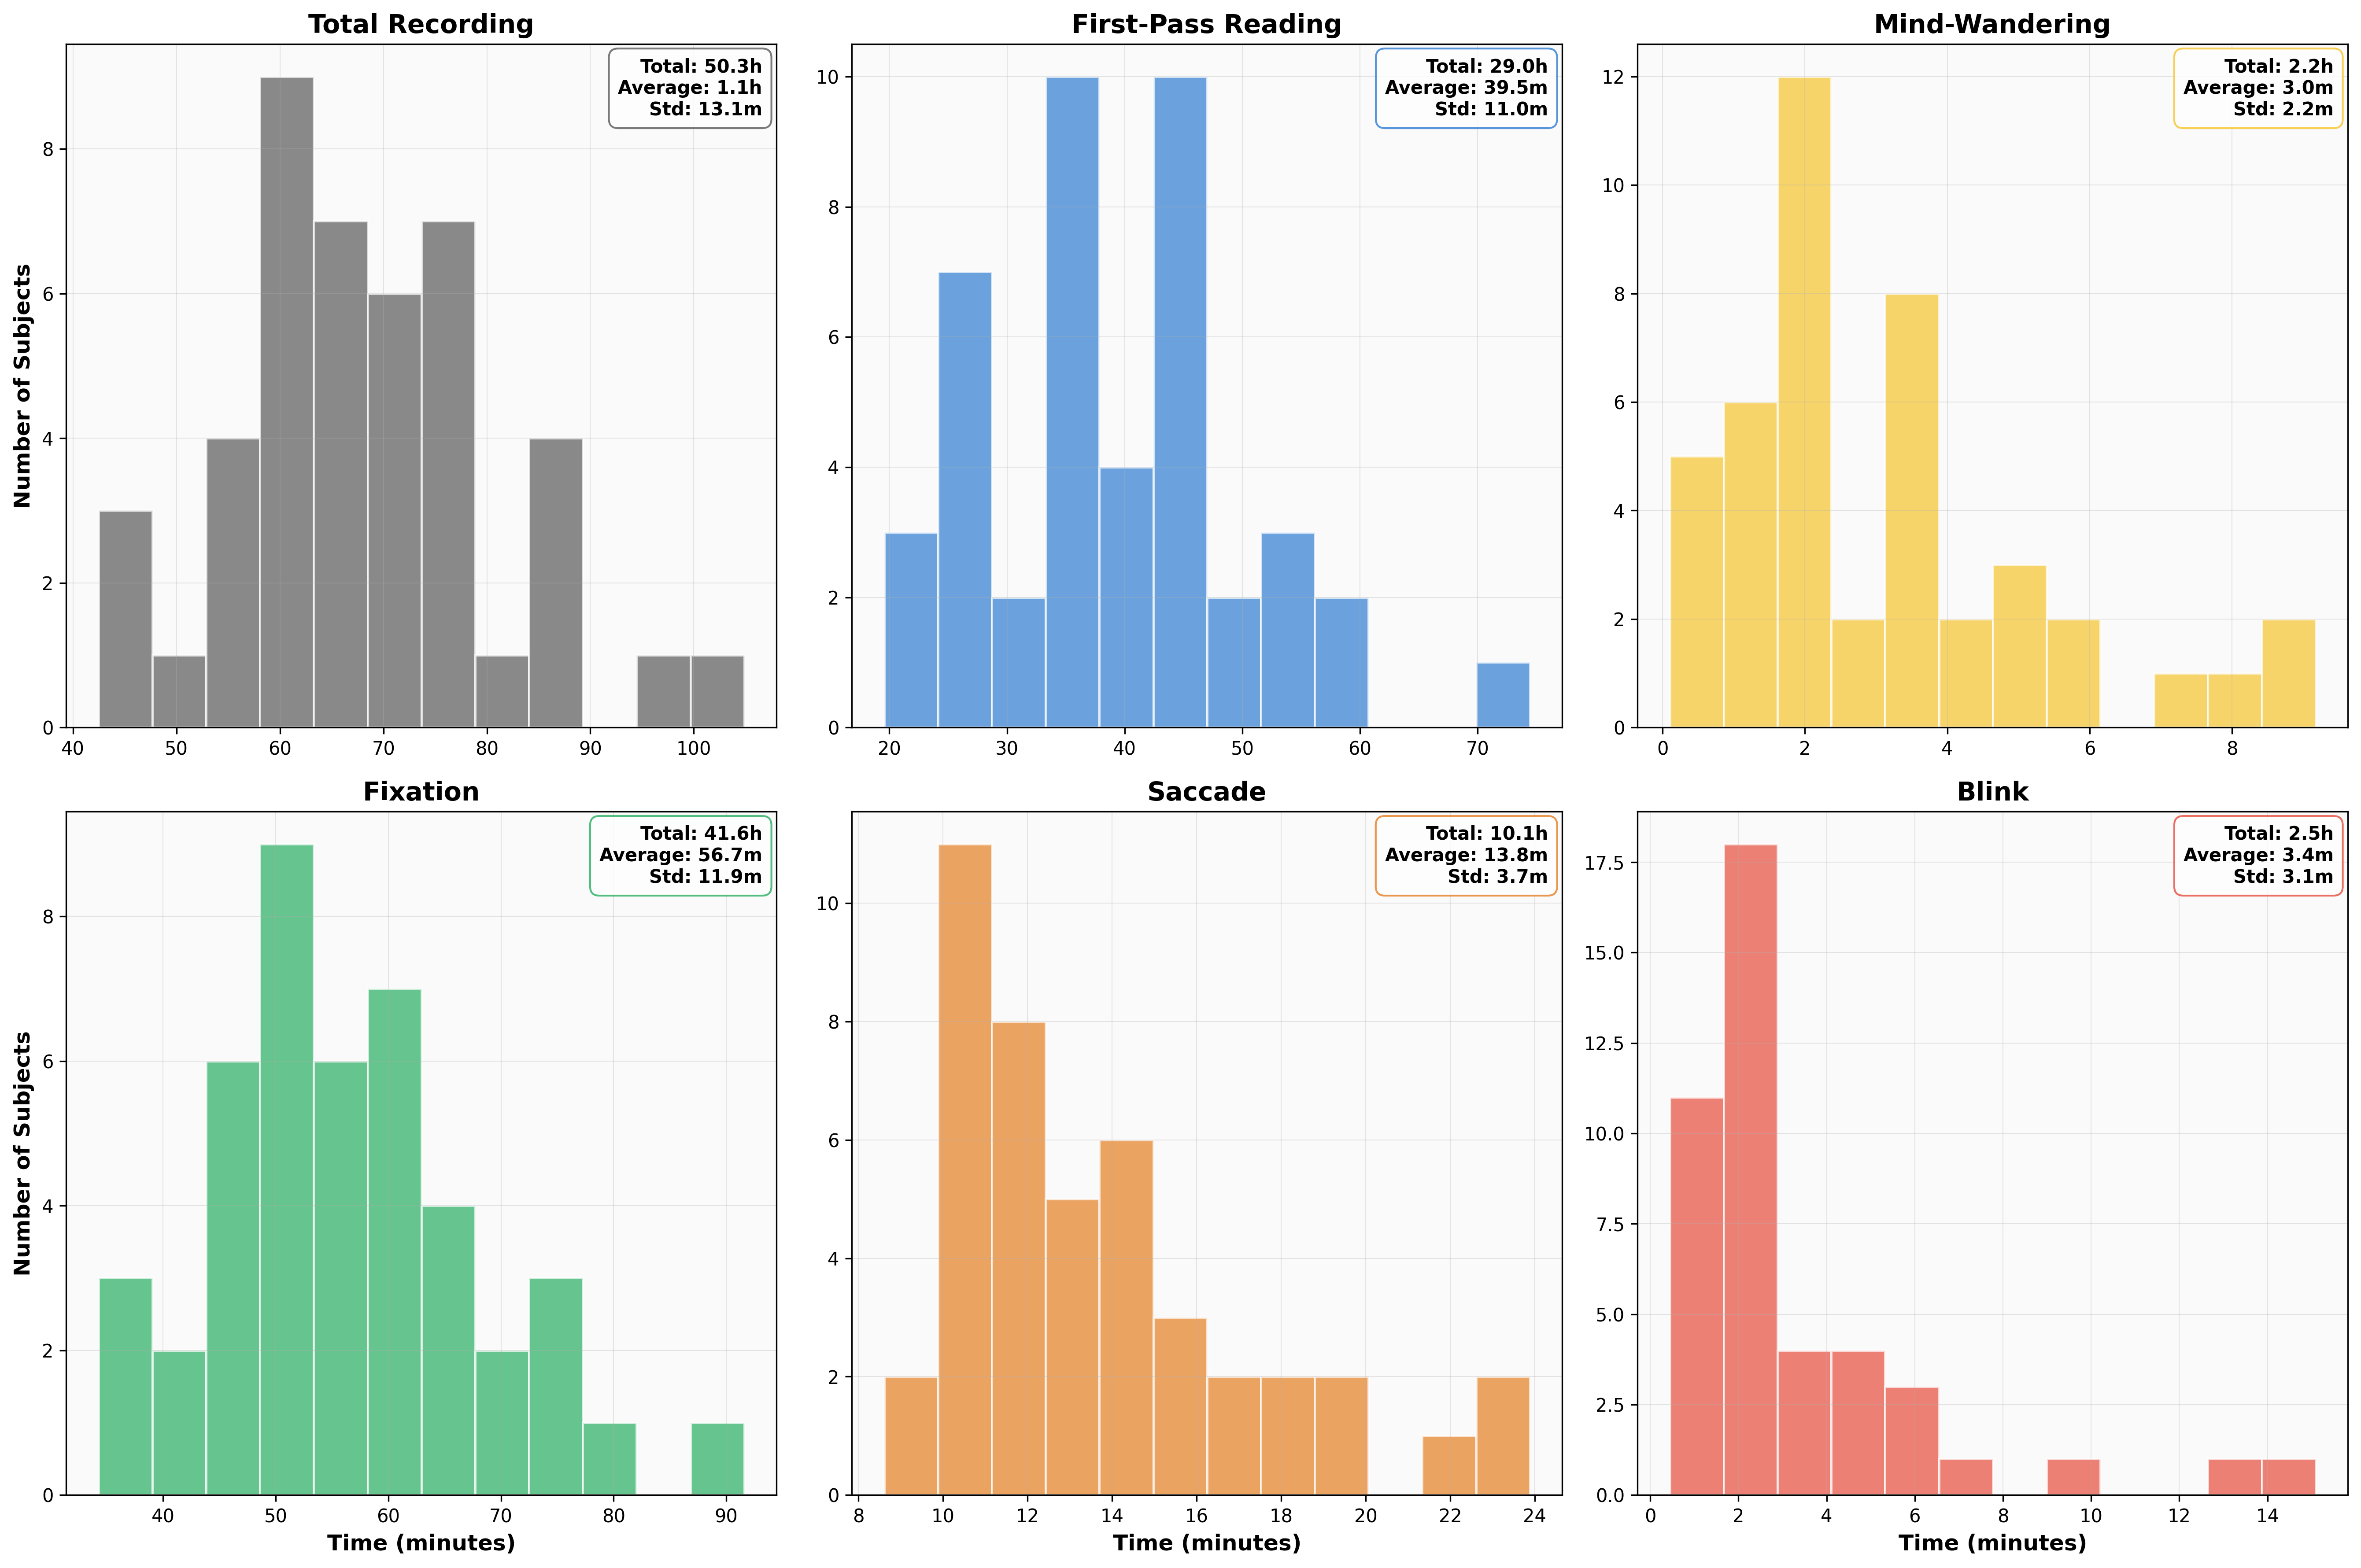


📊 DATASET SUMMARY TABLE FOR BLOG POST
Data Type            Total Time   Avg/Subject  Std Dev   
------------------------------------------------------------
Total Recording      50.3h        68.6m        13.1m     
First-Pass Reading   29.0h        39.5m        11.0m     
Mind-Wandering       2.2h         3.0m         2.2m      
Fixation             41.6h        56.7m        11.9m     
Saccade              10.1h        13.8m        3.7m      
Blink                2.5h         3.4m         3.1m      

📈 Key Insights:
• First-pass reading comprises 57.6% of total recording time
• Participants spent 82.6% of time in fixations
• Average reading session: 39m 29.6s per subject
• Data collection efficiency: 57.6% actual reading vs. total time

Total number of samples:  46371584 seconds:  181139.0
Total number of first pass samples:  26691014 seconds:  104261.7734375
Total number of fixation samples:  38324700 seconds:  149705.859375
Total number of saccade samples:  9326633 seconds:  36432.1

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def seconds_to_hours_minutes(seconds):
    """Convert seconds to hours and minutes format"""
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    remaining_seconds = seconds % 60
    
    if hours > 0:
        return f"{hours}h {minutes}m {remaining_seconds:.1f}s"
    elif minutes > 0:
        return f"{minutes}m {remaining_seconds:.1f}s"
    else:
        return f"{remaining_seconds:.1f}s"

# define sampling frequency
fs = 256  # Hz 
# load data scale
data_scale = pd.read_csv('../res/data_scale.csv')

# Calculate total times in seconds
total_all_seconds = data_scale['all_samples'].sum() / fs
total_first_seconds = data_scale['first_samples'].sum() / fs
total_fixation_seconds = data_scale['fixation_samples'].sum() / fs
total_saccade_seconds = data_scale['saccade_samples'].sum() / fs
total_blink_seconds = data_scale['blink_samples'].sum() / fs
total_mw_seconds = data_scale['mw_samples'].sum() / fs

print(f"📊 Total All Data Time: {seconds_to_hours_minutes(total_all_seconds)} ({total_all_seconds:.1f} seconds)")
print(f"📖 Total First-Pass Reading Time: {seconds_to_hours_minutes(total_first_seconds)} ({total_first_seconds:.1f} seconds)")
print(f"👁️  Total Fixation Time: {seconds_to_hours_minutes(total_fixation_seconds)} ({total_fixation_seconds:.1f} seconds)")
print(f"↗️  Total Saccade Time: {seconds_to_hours_minutes(total_saccade_seconds)} ({total_saccade_seconds:.1f} seconds)")
print(f"👀 Total Blink Time: {seconds_to_hours_minutes(total_blink_seconds)} ({total_blink_seconds:.1f} seconds)")
print(f"🧠 Total Mind-Wandering Time: {seconds_to_hours_minutes(total_mw_seconds)} ({total_mw_seconds:.1f} seconds)")

# Calculate percentages
print(f"\n📊 PROPORTIONS:")
print(f"First-pass reading: {(total_first_seconds/total_all_seconds)*100:.1f}% of all data")
print(f"Fixations: {(total_fixation_seconds/total_all_seconds)*100:.1f}% of all data")
print(f"Saccades: {(total_saccade_seconds/total_all_seconds)*100:.1f}% of all data")
print(f"Blinks: {(total_blink_seconds/total_all_seconds)*100:.1f}% of all data")
print(f"Mind-wandering: {(total_mw_seconds/total_all_seconds)*100:.1f}% of all data")

# Per subject averages
n_subjects = len(data_scale)
print(f"\n👥 PER SUBJECT AVERAGES ({n_subjects} subjects):")
print(f"All data: {seconds_to_hours_minutes(total_all_seconds/n_subjects)}")
print(f"First-pass reading: {seconds_to_hours_minutes(total_first_seconds/n_subjects)}")
print(f"Fixations: {seconds_to_hours_minutes(total_fixation_seconds/n_subjects)}")
print(f"Saccades: {seconds_to_hours_minutes(total_saccade_seconds/n_subjects)}")
print(f"Blinks: {seconds_to_hours_minutes(total_blink_seconds/n_subjects)}")
print(f"Mind-wandering: {seconds_to_hours_minutes(total_mw_seconds/n_subjects)}")

# Create beautiful histograms for blog post
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for publication-quality plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Convert all sample counts to minutes for better readability
data_scale_minutes = data_scale.copy()
data_scale_minutes['all_minutes'] = data_scale['all_samples'] / fs / 60
data_scale_minutes['first_minutes'] = data_scale['first_samples'] / fs / 60
data_scale_minutes['fixation_minutes'] = data_scale['fixation_samples'] / fs / 60
data_scale_minutes['saccade_minutes'] = data_scale['saccade_samples'] / fs / 60
data_scale_minutes['blink_minutes'] = data_scale['blink_samples'] / fs / 60
data_scale_minutes['mw_minutes'] = data_scale['mw_samples'] / fs / 60

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Define colors for each plot
colors = ['grey', 'blue', 'yellow', 'green', 'orange', 'red']
colors = ['#5a5a5a', '#2e7dd2', '#f7c52d', '#27ae60', '#e67e22', '#e74c3c']  # grey, blue, yellow, green, orange, red
metrics = [
    ('all_minutes', 'Total Recording'),
    ('first_minutes', 'First-Pass Reading'),
    ('mw_minutes', 'Mind-Wandering'),
    ('fixation_minutes', 'Fixation'),
    ('saccade_minutes', 'Saccade'),
    ('blink_minutes', 'Blink')
]

# Flatten axes for easier iteration
axes_flat = axes.flatten()

for idx, (metric, title) in enumerate(metrics):
    ax = axes_flat[idx]
    data = data_scale_minutes[metric]
    
    # Create histogram
    n, bins, patches = ax.hist(data, bins=12, alpha=0.7, color=colors[idx], 
                              edgecolor='white', linewidth=1.2)
    
    # Calculate statistics
    total_time = data.sum()
    avg_time = data.mean()
    std_time = data.std()
    
    # Format time labels
    if total_time >= 60:
        total_label = f"{total_time/60:.1f}h"
    else:
        total_label = f"{total_time:.1f}m"
        
    if avg_time >= 60:
        avg_label = f"{avg_time/60:.1f}h"
    else:
        avg_label = f"{avg_time:.1f}m"
    
    # Add statistics text box
    stats_text = f"Total: {total_label}\nAverage: {avg_label}\nStd: {std_time:.1f}m"
    
    # Position text box
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor=colors[idx]),
            fontsize=10, fontweight='bold')
    
    
    
    # Customize axes
    ax.set_title(f'{title}', fontweight='bold')
    if idx in [0, 3]:
        ax.set_ylabel('Number of Subjects', fontweight='bold')
    if idx in [3, 4, 5]:
        ax.set_xlabel('Time (minutes)', fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    # ax.legend(loc='upper left', fontsize=9)
    
    # Improve x-axis formatting
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Add subtle background color
    ax.set_facecolor('#fafafa')

# Adjust layout
plt.tight_layout()
plt.show()

# Create a summary table for the blog post
print("\n" + "="*80)
print("📊 DATASET SUMMARY TABLE FOR BLOG POST")
print("="*80)

summary_data = []
for metric, title in metrics:
    data = data_scale_minutes[metric]
    total_time = data.sum()
    avg_time = data.mean()
    std_time = data.std()
    
    # Format for table
    if total_time >= 60:
        total_formatted = f"{total_time/60:.1f}h"
    else:
        total_formatted = f"{total_time:.0f}m"
        
    avg_formatted = f"{avg_time:.1f}m"
    std_formatted = f"{std_time:.1f}m"
    
    summary_data.append([title, total_formatted, avg_formatted, std_formatted])

# Print formatted table
print(f"{'Data Type':<20} {'Total Time':<12} {'Avg/Subject':<12} {'Std Dev':<10}")
print("-" * 60)
for row in summary_data:
    print(f"{row[0]:<20} {row[1]:<12} {row[2]:<12} {row[3]:<10}")

print(f"\n📈 Key Insights:")
first_pass_percent = (total_first_seconds/total_all_seconds)*100
fixation_percent = (total_fixation_seconds/total_all_seconds)*100
print(f"• First-pass reading comprises {first_pass_percent:.1f}% of total recording time")
print(f"• Participants spent {fixation_percent:.1f}% of time in fixations")
print(f"• Average reading session: {seconds_to_hours_minutes(total_first_seconds/n_subjects)} per subject")
print(f"• Data collection efficiency: {first_pass_percent:.1f}% actual reading vs. total time")

print("\nTotal number of samples: ", data_scale['all_samples'].sum(), "seconds: ", data_scale['all_samples'].sum() / fs)
print("Total number of first pass samples: ", data_scale['first_samples'].sum(), "seconds: ", data_scale['first_samples'].sum() / fs)
print("Total number of fixation samples: ", data_scale['fixation_samples'].sum(), "seconds: ", data_scale['fixation_samples'].sum() / fs)
print("Total number of saccade samples: ", data_scale['saccade_samples'].sum(), "seconds: ", data_scale['saccade_samples'].sum() / fs)
print("Total number of blink samples: ", data_scale['blink_samples'].sum(), "seconds: ", data_scale['blink_samples'].sum() / fs)
print("Total number of mw samples: ", data_scale['mw_samples'].sum(), "seconds: ", data_scale['mw_samples'].sum() / fs)

## Word count for readings

In [ ]:
import pandas as pd

# Story files
stories = {
    'History of Film': '../res/history_of_film_control_coordinates.csv',
    'Pluto': '../res/pluto_control_coordinates.csv', 
    'Prisoners Dilemma': '../res/prisoners_dilemma_control_coordinates.csv',
    'Serena Williams': '../res/serena_williams_control_coordinates.csv',
    'The Voynich Manuscript': '../res/the_voynich_manuscript_control_coordinates.csv'
}

print("📚 READING STORIES WORD COUNT ANALYSIS")
print("=" * 60)

results = []
total_words = 0
total_unique_words = 0

for story_name, file_path in stories.items():
    try:
        # Read only the words column efficiently
        df = pd.read_csv(file_path, usecols=['words'])
        word_count = len(df)
        unique_words = df['words'].nunique()
        
        results.append({
            'Story': story_name,
            'Total Words': word_count,
            'Unique Words': unique_words,
            'Richness %': round(unique_words/word_count*100, 1)
        })
        
        total_words += word_count
        total_unique_words += unique_words
        print(f"📖 {story_name:<25} {word_count:>6,} words ({unique_words:>4,} unique)")
        
    except Exception as e:
        print(f"❌ Error reading {story_name}: {e}")

print("-" * 60)
print(f"📊 TOTAL ACROSS ALL STORIES: {total_words:>8,} words")
print(f"📊 TOTAL UNIQUE WORDS: {total_unique_words:>8,} words")
print(f"📈 AVERAGE PER STORY:        {total_words//5:>8,} words")

# Find min/max
if results:
    min_story = min(results, key=lambda x: x['Total Words'])
    max_story = max(results, key=lambda x: x['Total Words'])
    
    print(f"📉 SHORTEST: {min_story['Story']} ({min_story['Total Words']:,} words)")
    print(f"📈 LONGEST:  {max_story['Story']} ({max_story['Total Words']:,} words)")
    
    print("\n📚 VOCABULARY RICHNESS:")
    for result in sorted(results, key=lambda x: x['Richness %'], reverse=True):
        print(f"   {result['Story']:<25} {result['Richness %']:>5.1f}%")

📚 READING STORIES WORD COUNT ANALYSIS
📖 History of Film            2,141 words (1,023 unique)
📖 Pluto                      2,125 words ( 945 unique)
📖 Prisoners Dilemma          2,148 words ( 841 unique)
📖 Serena Williams            2,269 words ( 810 unique)
📖 The Voynich Manuscript     2,156 words ( 946 unique)
------------------------------------------------------------
📊 TOTAL ACROSS ALL STORIES:   10,839 words
📊 TOTAL UNIQUE WORDS:    4,565 words
📈 AVERAGE PER STORY:           2,167 words
📉 SHORTEST: Pluto (2,125 words)
📈 LONGEST:  Serena Williams (2,269 words)

📚 VOCABULARY RICHNESS:
   History of Film            47.8%
   Pluto                      44.5%
   The Voynich Manuscript     43.9%
   Prisoners Dilemma          39.2%
   Serena Williams            35.7%


# Demo on how to load ROAMM

In [ ]:
import os
import pandas as pd

# define data root
# this is the path to the ROAMM folder on local machine
roamm_root = r"/Users/~"
ml_data_root = os.path.join(roamm_root, 'subject_ml_data')

# =================================================================
# load a single run of ml data
subject_id = 's10014'
subject_dir = os.path.join(ml_data_root, subject_id)
run_number = 1
df_sub_single_run = pd.read_pickle(os.path.join(subject_dir, f'{subject_id}_run{run_number}_ml_data.pkl'))

# =================================================================
# load all runs for a subject
pkl_files = [f for f in os.listdir(subject_dir) if f.endswith('.pkl')]
df_sub_all_runs = pd.DataFrame()
for pkl_file in pkl_files:
    df_sub_single_run = pd.read_pickle(os.path.join(subject_dir, pkl_file))
    df_sub_all_runs = pd.concat([df_sub_all_runs, df_sub_single_run])

# =================================================================
# load all runs for all subjects
all_subjects = [d for d in os.listdir(ml_data_root) if d.startswith('s') and os.path.isdir(os.path.join(ml_data_root, d))]
df = pd.DataFrame()
for subject_id in all_subjects:
    subject_dir = os.path.join(ml_data_root, subject_id)
    pkl_files = [f for f in os.listdir(subject_dir) if f.endswith('.pkl')]

    # make sure each subject has 5 runs of data
    if len(pkl_files) != 5:
        raise ValueError(f"Subject {subject_id} has {len(pkl_files)} runs instead of 5")
    
    for pkl_file in pkl_files:
        df_sub_single_run = pd.read_pickle(os.path.join(subject_dir, pkl_file))
        # I highly recommend you to filter out reading runs that are not the first pass reading
        # to save memory
        df_sub_single_run = df_sub_single_run[df_sub_single_run['first_pass_reading'] == 1]
        # add subject id to the dataframe   
        df_sub_single_run['subject_id'] = subject_id
        # convert bool col explicitly to avoid pandas warning
        for col in ['is_blink', 'is_saccade', 'is_fixation', 'is_mw', 'first_pass_reading']:
            df_sub_single_run[col] = df_sub_single_run[col] == True
        # append to the dataframe
        df = pd.concat([df, df_sub_single_run])
    
    print(f'Subject {subject_id} has been loaded.')


Subject s10014 has been loaded.
